In [819]:
from qutip import *
import numpy as np
import matplotlib.pyplot as plt
from scipy.fft import fftshift, fft, fftfreq

We define the Transmon Hamiltonian. Note that $\hat{n}, \hat{1},$ and $\hat{\phi}$ are all Qobj's now:

In [820]:
# In the charge basis, n is diagonal
n_cutoff = 10
size = 2*n_cutoff + 1
diagonals_n = np.arange(size + 1) - n_cutoff
n = Qobj(np.diag(diagonals_n, 0))

# Identity matrix
I = identity(size + 1)

# The cosine of the reduced phase operator in the charge basis is implemented 
# using eqs. (16) and (18) from https://arxiv.org/pdf/2106.05342
ones = 1/2*np.ones(size) 
data = np.array([ones, ones])
offsets = np.array([-1, 1])
cos_phi = Qobj(np.diag(data[0], offsets[0]) + np.diag(data[1], offsets[1]))

# The Hamiltonian is also a Qobj then:
def hamiltonian_n(EC, EJ, ng, phi_ext, d):
    H = 4*EC*(n @ n + ng**2*I - 2*ng*I @ n) - EJ*np.sqrt(np.cos(phi_ext)**2 + d**2*np.sin(phi_ext)**2)*cos_phi
    return H

# We use QuTip to find the eigenstates and energies for n_g = phi_ext = d = 0$:
energies = hamiltonian_n(0.3, 15, 0, 0, 0).eigenenergies()
vecs = hamiltonian_n(0.3, 15, 0, 0, 0).eigenstates()

# The anharmonicity, alpha, is found:
alpha = energies[2] - energies[1] - energies[1] + energies[0]
energies -= energies[0]
energies = energies[:3]

# We define the qubit frequency and the coupling strengths:
w01 = energies[1]
w02 = energies[2]
HQ = Qobj(np.diag(energies))

HC = np.ndarray((3, 3), dtype=complex)
for i in range(3):
    for j in range(3):
        HC[i,j] = vecs[1][i].dag() @ n @ vecs[1][j]
g1 = HC[0,1]
g2 = HC[1,2]
HC = Qobj(HC)

The anharmonicity $\alpha = \omega_{12} - \omega_{01}$ is -343MHz. We now have $H_Q$ and $H_C$ as follows:

In [821]:
HQ

Quantum object: dims=[[3], [3]], shape=(3, 3), type='oper', dtype=Dense, isherm=True
Qobj data =
[[ 0.          0.          0.        ]
 [ 0.          5.68257568  0.        ]
 [ 0.          0.         11.02038445]]

In [822]:
HC

Quantum object: dims=[[3], [3]], shape=(3, 3), type='oper', dtype=Dense, isherm=True
Qobj data =
[[-7.85432708e-17  1.08780080e+00 -8.38427611e-16]
 [ 1.08780080e+00  1.42550298e-14  1.49027312e+00]
 [-8.38319137e-16  1.49027312e+00  1.59342126e-13]]

with coupling terms g1 = 1.09 and g2 = 1.49. Now we're interested in the dynamics of the system when we're driving on resonance. We define the envelope function $s(t)$ and the amplitude $A = \pi / (g_1 \cdot \int dt s(t) ) $. First, we use a Gaussian function:

In [823]:
def gauss(t, t0, sigma): # Gaussian envelope. Sigma is standard deviation
    return 1/(np.sqrt(2*np.pi)*sigma)*np.exp(-(t - t0)**2/(2*sigma**2)) # We move the Gaussian peak to t0

A = np.abs(np.pi/g1)

# For the Gaussian envelope,  we define the time-dependent coefficient for use in QuTip mesolve:
def HC_gauss(t, args):
    sigma = args['sigma']
    t0 = args['t0']
    phi0 = args['phi_0']
    wd = args['wd']
    return A * gauss(t, t0, sigma) * (np.cos(phi0) * np.sin(wd*t) + np.sin(phi0) * np.cos(wd*t))

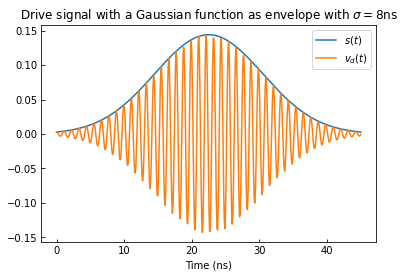

In [824]:
T_max = 45 # Plotting time length
t = np.linspace(0, T_max, 500)
plt.plot(t, A * gauss(t, T_max/2, 8), label=r'$s(t)$')
plt.plot(t, A * gauss(t, T_max/2, 8) * np.cos(w01*t), label=r'$v_d(t)$') # A * s(t) * cos(w_01*t)
plt.xlabel('Time (ns)')
plt.legend()
plt.title(f'Drive signal with a Gaussian function as envelope with $\sigma = {sigm}$ns')
plt.tick_params(axis='both', direction='in')
plt.savefig("drive_signal_Gaussian_envelope.jpg", dpi=300)

plt.show()

In [825]:
H = [HQ, [HC, HC_gauss]] # List of Hamiltonians and their coefficients
psi0 = basis(3,0) # Initial state [1,0,0]
times = np.linspace(0, T_max, 1000)
args = {'sigma': 8, 't0': T_max/2, 'phi_0': 0, 'wd': w01, 'theta': 0} # Arguments for the time-dependent coefficient
sol = mesolve(H, psi0, times, args=args) 

In [826]:
# Helper function to calculate overlap between two states
def prob(solution, t, x):
    return np.abs(solution.states[t].dag() @ basis(3,x))**2

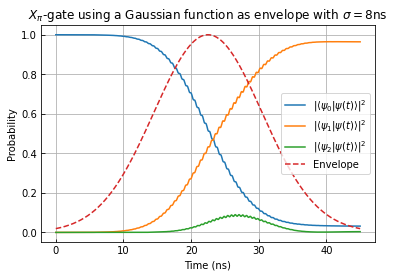

In [827]:
for i in range(3):
    plt.plot(sol.times, [prob(sol, t, i) for t in range(len(sol.times))], label = f'$| \\langle \\psi_{i} | \\psi(t) \\rangle |^2$')
plt.plot(times, gauss(times, args['t0'], args['sigma'])/np.max(gauss(times, args['t0'], args['sigma'])), '--', label = 'Envelope')
plt.legend()
plt.xlabel('Time (ns)')
plt.ylabel('Probability')
plt.tick_params(axis='both', direction = 'in')
sigm = args['sigma']
plt.title(f'$X_\\pi$-gate using a Gaussian function as envelope with $\\sigma = {sigm}$ns')
plt.grid()

plt.savefig("X_pi_gate_Gaussian_envelope.jpg", dpi=300)
plt.show()

There are some interesting points to make. (1) We see the piecewise action of the rotation, i.e. the staircase pattern on the curves, (2) from $H_C$ we know that no transitions $\ket{0} \rightarrow \ket{2}$ take place. Therefore, the green line lags the yellow line, since only $\ket{1} \rightarrow \ket{2}$ happens, and (3) the implementation does not with certainty perform an X-gate. Different $\sigma$'s yield different results. One can optimize for the maximum fidelity as we will show later. For now, let's test the fidelity of this gate. We use the computational subspace of the three-level system to find the process- and mean fidelities using QuTip and the method from https://arxiv.org/pdf/quant-ph/0701138:

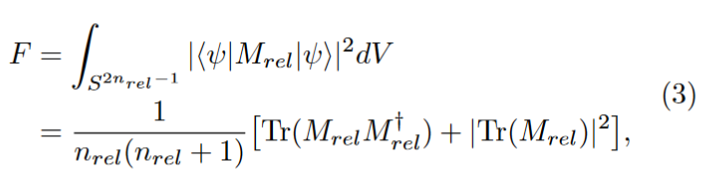

In [828]:
# We find the unitary operator for the time evolution
U = propagator(H, T_max, args=args, options=Options(nsteps=100000))
U_comp = Qobj(U[0:2,0:2])
U_comp

c:\Users\leouh\AppData\Local\Programs\Python\Python310\lib\site-packages\qutip\solver\options.py:16: FutureWarning: Dedicated options class are no longer needed, options should be passed as dict to solvers.
  warnings.warn(


Quantum object: dims=[[2], [2]], shape=(2, 2), type='oper', dtype=Dense, isherm=False
Qobj data =
[[ 0.0798335 +0.15985535j -0.95323008+0.2355871j ]
 [-0.07998216+0.97866757j  0.1729028 +0.05564578j]]

We see that in fact, we're not performing an X-gate but a rotation about some different angle in the xy-plane. This is due to spin precession during the gate time, and we can correct for this by performing an RZ-gate and adding a global phase:

In [829]:
# Function to rotate the qubit after having performed the gate
def rotate(U):
    phi = (np.angle(U[1,0]) - np.angle(U[0,1])) / 2
    theta = (np.angle(U[1,0]) + np.angle(U[0,1])) / 2
    global_phase = np.exp(-1j*theta)
    virtual_z = Qobj(   [[np.exp(1j*phi), 0],
                     [0, np.exp(-1j*phi)]]  )
    return global_phase * virtual_z * U

In [830]:
U_rotated = rotate(U_comp)
U_rotated

Quantum object: dims=[[2], [2]], shape=(2, 2), type='oper', dtype=Dense, isherm=False
Qobj data =
[[-0.03914799-1.74340349e-01j  0.98191083+1.94289029e-16j]
 [ 0.98193042+5.55111512e-17j  0.04137725-1.76860836e-01j]]

Now we have something that closely resembles an X-gate. The fidelity:

In [831]:
print(f'Entanglement fidelity: {round(process_fidelity(U_rotated, sigmax()),5)} and mean fidelity: {round(average_gate_fidelity(U_rotated, sigmax()),5)}')

Entanglement fidelity: 0.96417 and mean fidelity: 0.97611


In [832]:
# Using the method from https://arxiv.org/pdf/quant-ph/0701138:
prod1 = U_rotated.dag() @ U_rotated
prod2 = U_rotated.dag() @ sigmax()
print(f'Mean fidelity using equation (3): {round(1/6*(prod1.tr() + np.abs(prod2.tr()**2)),5)}')

Mean fidelity using equation (3): 0.97499


We might try to improve the fidelity by increasing the gate time, thereby reducing the width of the pulse in frequency space. This, of course, is done using a larger standard deviation $\sigma$ for the Gaussian envelope:

In [833]:
T_max = 400
args = {'sigma': T_max/10, 't0': T_max/2, 'phi_0': 0, 'wd': w01, 'theta': 0} # Arguments for the time-dependent coefficient
times = np.linspace(0, T_max, 1000)
sol = mesolve(H, psi0, times, args=args) 
U = propagator(H, T_max, args=args, options=Options(nsteps=100000))
U_comp = Qobj(U[0:2,0:2])
U_rotated = rotate(U_comp)
U_rotated

Quantum object: dims=[[2], [2]], shape=(2, 2), type='oper', dtype=Dense, isherm=False
Qobj data =
[[-0.00111458-3.58706600e-02j  0.99921519+5.06539255e-16j]
 [ 0.99921529+2.77555756e-16j  0.00104801-3.58608691e-02j]]

In [834]:
print(f'Entanglement fidelity: {round(process_fidelity(U_rotated, sigmax()),5)} and mean fidelity: {round(average_gate_fidelity(U_rotated, sigmax()),5)}')

Entanglement fidelity: 0.99843 and mean fidelity: 0.99895


A higher fidelity! The down-side of this is of course, that now an X-gate takes 400ns... We can try to increase the fidelity by implementing DRAG. To this end, we re-design our envelope function to $s(t) = 1 - \cos(2\pi t/\tau_g)$ where $\tau_g$ is the gate time:

In [835]:
def cosine_envelope(t, tau_g): # Cosine envelope
    A = np.abs(np.pi/(g1*tau_g))
    return A * (1 - np.cos(2*np.pi*t/tau_g))

def diff_cosine_envelope(t, tau_g): # Derivative of the cosine envelope is A * 2*pi*t/tau_g*sin(2*pi*t/tau_g)
    A = np.abs(np.pi/(g1*tau_g))
    return A * 2*np.pi/tau_g * np.sin(2*np.pi*t/tau_g)

def HC_drag(t, args): 
    tau_g = args['tau_g']
    wd = args['wd']
    lambd = args['lambda']
    return (cosine_envelope(t, tau_g) * np.sin(wd*t) + lambd * diff_cosine_envelope(t, tau_g)/alpha * np.cos(wd*t))

First, we drive the gate using the cosine envelope but without DRAG ($\lambda = 0$):

In [836]:
args = {'tau_g': 45, 'wd': w01, 'lambda': 0, 'sigma': 8, 't0': 45/2, 'phi_0': 0}
times_drag = np.linspace(0, args['tau_g'], 1000)
H_drag = [HQ, [HC, HC_drag]]
sol_drag = mesolve(H_drag, psi0, times_drag, args=args)

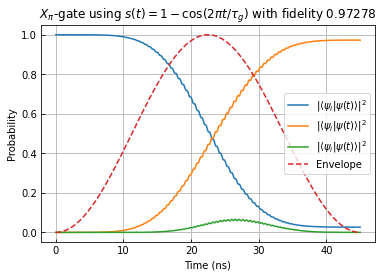

In [837]:
for i in range(3):
    plt.plot(sol_drag.times, [prob(sol_drag, t, i) for t in range(len(sol_drag.times))], label = r'$| \langle \psi_{i} | \psi(t) \rangle |^2$')
plt.plot(times_drag, cosine_envelope(times_drag, args['tau_g'])/np.max(cosine_envelope(times, args['tau_g'])), '--', label = 'Envelope')
plt.legend()
plt.xlabel('Time (ns)')
plt.ylabel('Probability')
plt.tick_params(axis='both', direction = 'in')
plt.grid()
plt.title(f'$X_\pi$-gate using $s(t) = 1 - \cos(2 \pi t / \\tau_g)$ with fidelity 0.97278')

plt.savefig("X_pi_gate_cosine_envelope.jpg", dpi=300)
plt.show()

In [838]:
U_cosine = propagator(H_drag, args['tau_g'], args=args, options=Options(nsteps=100000))
U_cosine = rotate(Qobj(U_cosine[0:2,0:2]))
U_cosine

c:\Users\leouh\AppData\Local\Programs\Python\Python310\lib\site-packages\qutip\solver\options.py:16: FutureWarning: Dedicated options class are no longer needed, options should be passed as dict to solvers.
  warnings.warn(


Quantum object: dims=[[2], [2]], shape=(2, 2), type='oper', dtype=Dense, isherm=False
Qobj data =
[[-0.02462825-1.61772141e-01j  0.98629806+5.55111512e-17j]
 [ 0.98629818+9.71445147e-17j  0.02424333-1.61856315e-01j]]

In [839]:
print(f'Entanglement fidelity: {round(process_fidelity(U_cosine, sigmax()),5)} and mean fidelity: {round(average_gate_fidelity(U_cosine, sigmax()),5)}')

Entanglement fidelity: 0.97278 and mean fidelity: 0.98186


At this point, the 45ns gate time cosine envelope performs marginally better than the 8ns standard deviation Gaussian pulse (~48ns gate time). Let's try to optimize the DRAG parameter, the drive frequency and the gate time in order to reach an even higher fidelity! 

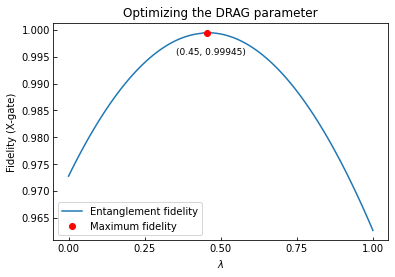

In [840]:
ls = np.linspace(0, 1, 100)
fidelities = []

for l in ls:
    args['lambda'] = l
    U = propagator(H_drag, args['tau_g'], args=args, options=Options(nsteps=10000))
    U_comp = rotate(Qobj(U[0:2,0:2]))
    fidelities.append(process_fidelity(U_comp, sigmax()))

plt.plot(ls, fidelities, label = 'Entanglement fidelity')

max_fidelity = max(fidelities)
max_lambda = ls[fidelities.index(max_fidelity)]
args['lambda'] = max_lambda
plt.plot(max_lambda, max_fidelity, 'ro', label='Maximum fidelity')  # Plot the maximum point
plt.text(max_lambda + 0.128, max_fidelity - 0.004, f'({max_lambda:.2f}, {max_fidelity:.5f})', fontsize=9, ha='right')

plt.legend()
plt.xlabel('$\lambda$')
plt.ylabel('Fidelity (X-gate)')
plt.xticks([0, 0.25, 0.5, 0.75, 1])
plt.tick_params(axis='both', direction = 'in')
plt.title('Optimizing the DRAG parameter')

plt.savefig("DRAG_parameter.jpg", dpi=300)
plt.show()

There's clearly an optimal value which yields a very high fidelity! We use $\lambda = 0.45$ and proceed to optimize the drive frequency:

c:\Users\leouh\AppData\Local\Programs\Python\Python310\lib\site-packages\qutip\solver\options.py:16: FutureWarning: Dedicated options class are no longer needed, options should be passed as dict to solvers.
  warnings.warn(


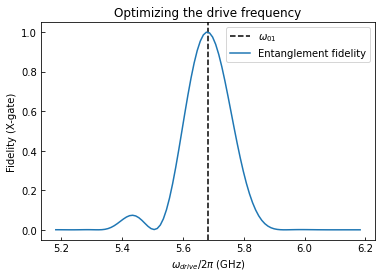

In [841]:
freqs = w01 + np.linspace(-0.5, 0.5, 100)
fidelities = []

for w in freqs:
    args['wd'] = w
    args['lambda'] = 0.5
    U = propagator(H_drag, args['tau_g'], args=args, options=Options(nsteps=10000))
    U_comp = Qobj(U[0:2,0:2])
    phi = (np.angle(U_comp[1,0]) - np.angle(U_comp[0,1])) / 2
    theta = (np.angle(U_comp[1,0]) + np.angle(U_comp[0,1])) / 2
    global_phase = np.exp(-1j*theta)
    virtual_z = Qobj(   [[np.exp(1j*phi), 0],
                     [0, np.exp(-1j*phi)]]  )
    U_comp = global_phase * virtual_z * U_comp
    fidelities.append(process_fidelity(U_comp, sigmax()))

plt.axvline(x=w01, color='black', linestyle='--', label=r'$\omega_{01}$')

plt.plot(freqs, fidelities, label = 'Entanglement fidelity')
plt.xlabel('$\omega_{drive}/2\pi$ (GHz)')
plt.ylabel('Fidelity (X-gate)')
plt.tick_params(axis='both', direction = 'in')
plt.legend()
plt.title('Optimizing the drive frequency')

plt.savefig("Drive_frequency.jpg", dpi=300)
plt.show()

For this value of $\lambda$, there's not a lot to gain from detuning the drive frequency. One might want to re-iterate the optimization process, because we're looking to optimize three parameters (the gate time will be optimized in the following), so clearly, optimizing $\lambda$, then $\omega_d$ and finally $\tau_g$ does not guarantee the optimal combination. But that's for future work.

c:\Users\leouh\AppData\Local\Programs\Python\Python310\lib\site-packages\qutip\solver\options.py:16: FutureWarning: Dedicated options class are no longer needed, options should be passed as dict to solvers.
  warnings.warn(


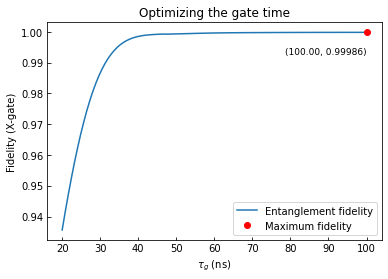

In [814]:
gate_times = np.linspace(20, 100, 100)
fidelities = []
args['wd'] = w01

for t in gate_times:
    args['tau_g'] = t
    U = propagator(H_drag, args['tau_g'], args=args, options=Options(nsteps=10000))
    U_comp = rotate(Qobj(U[0:2,0:2]))
    fidelities.append(process_fidelity(U_comp, sigmax()))

plt.plot(gate_times, fidelities, label = 'Entanglement fidelity')

max_fidelity = max(fidelities)
max_tau_g = gate_times[fidelities.index(max_fidelity)]
args['tau_g'] = max_tau_g
plt.plot(max_tau_g, max_fidelity, 'ro', label='Maximum fidelity')  # Plot the maximum point
plt.text(max_tau_g, max_fidelity - 0.007, f'({max_tau_g:.2f}, {max_fidelity:.5f})', fontsize=9, ha='right')

plt.xlabel(r'$\tau_{g}$ (ns)')
plt.ylabel('Fidelity (X-gate)')
plt.tick_params(axis='both', direction = 'in')
plt.legend()
plt.title('Optimizing the gate time')

plt.savefig("Gate_time.jpg", dpi=300)
plt.show()

c:\Users\leouh\AppData\Local\Programs\Python\Python310\lib\site-packages\qutip\solver\options.py:16: FutureWarning: Dedicated options class are no longer needed, options should be passed as dict to solvers.
  warnings.warn(


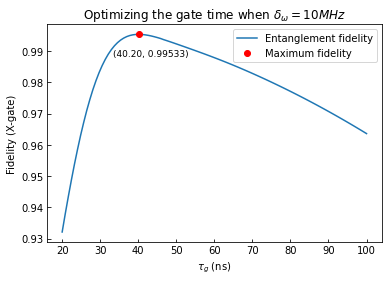

In [845]:
gate_times = np.linspace(20, 100, 100)
fidelities = []
args['wd'] = w01 - 0.01

for t in gate_times:
    args['tau_g'] = t
    U = propagator(H_drag, args['tau_g'], args=args, options=Options(nsteps=10000))
    U_comp = rotate(Qobj(U[0:2,0:2]))
    fidelities.append(process_fidelity(U_comp, sigmax()))

plt.plot(gate_times, fidelities, label = 'Entanglement fidelity')

max_fidelity = max(fidelities)
max_tau_g = gate_times[fidelities.index(max_fidelity)]
args['tau_g'] = max_tau_g
plt.plot(max_tau_g, max_fidelity, 'ro', label='Maximum fidelity')  # Plot the maximum point
plt.text(max_tau_g + 13, max_fidelity - 0.007, f'({max_tau_g:.2f}, {max_fidelity:.5f})', fontsize=9, ha='right')

plt.xlabel(r'$\tau_{g}$ (ns)')
plt.ylabel('Fidelity (X-gate)')
plt.tick_params(axis='both', direction = 'in')
plt.legend()
plt.title('Optimizing the gate time when $\delta_\omega = 10MHz$')

plt.savefig("Gate_time_2.jpg", dpi=300)
plt.show()

Not surprisingly, when we're on resonance, the fidelity increases indefinitely with the gate time. This, of course has to do with the fact that as we increase the gate time, the pulse gets less wide in frequency space, thereby having less frequency content at $\omega_{12}$:

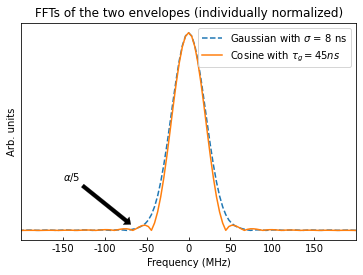

In [846]:
args = {'tau_g': 45, 'wd': w01, 'lambda': max_lambda, 'sigma': 8, 't0': 45/2, 'phi_0': 0}
times_drag = np.linspace(0, args['tau_g'], 1000)
N = len(times_drag)
dt = times_drag[1] - times_drag[0]  # Time step
zero_padding = 5000
frequencies = fftshift(fftfreq(N + zero_padding, dt))
gauss_pulse = gauss(times_drag, args['tau_g']/2, args['sigma'])
gauss_padded = np.pad(gauss_pulse, (0, zero_padding), 'constant')
gauss_fft = fftshift(np.abs(fft(gauss_padded)))
plt.plot(frequencies, 20*gauss_fft/gauss_fft.max(), '--', label=f'Gaussian with $\\sigma$ = {sigm} ns')

cosine_pulse = cosine_envelope(times_drag, args['tau_g'])
cosine_padded = np.pad(cosine_pulse, (0, zero_padding), 'constant')
cosine_fft = fftshift(np.abs(fft(cosine_padded)))
plt.plot(frequencies, 20*cosine_fft/cosine_fft.max(), label=f'Cosine with $\\tau_g = 45ns$') 

plt.xlim(-0.2, 0.2)
plt.xticks([-0.15, -0.1, -0.05, 0, 0.05, 0.1, 0.15], ['-150', '-100', '-50', '0', '50', '100', '150'])
plt.xlabel('Frequency (MHz)')
plt.legend()
plt.yticks([])
plt.ylabel('Arb. units')
plt.title('FFTs of the two envelopes (individually normalized)')
plt.tick_params(axis='x', direction='in')

plt.annotate(r'$\alpha / 5$', xy=(alpha/5, 0.6), xytext=(-0.15, 5),
             arrowprops=dict(facecolor='black', shrink=2, headwidth=10, headlength=6, linewidth=0.2))

plt.savefig("FFTs_of_envelopes.jpg", dpi=300)

plt.show()

We calculate the fidelity corresponding to the optimized values:

In [804]:
U = propagator(H_drag, args['tau_g'], args=args, options=Options(nsteps=10000))
U_comp = rotate(Qobj(U[0:2,0:2]))
fidelity = process_fidelity(U_comp, sigmax())
fidelity

c:\Users\leouh\AppData\Local\Programs\Python\Python310\lib\site-packages\qutip\solver\options.py:16: FutureWarning: Dedicated options class are no longer needed, options should be passed as dict to solvers.
  warnings.warn(


0.9994498854254502

In [809]:
Qobj(U[0:2,0:2])

Quantum object: dims=[[2], [2]], shape=(2, 2), type='oper', dtype=Dense, isherm=False
Qobj data =
[[ 0.01973207-0.00424274j -0.97653724+0.21406688j]
 [-0.1078586 +0.99388968j -0.00200164+0.01997956j]]

In [810]:
U_comp

Quantum object: dims=[[2], [2]], shape=(2, 2), type='oper', dtype=Dense, isherm=False
Qobj data =
[[-0.02018288-8.08074304e-05j  0.99972477+8.32667268e-17j]
 [ 0.99972504+3.05311332e-16j  0.0200789 -1.65605990e-04j]]

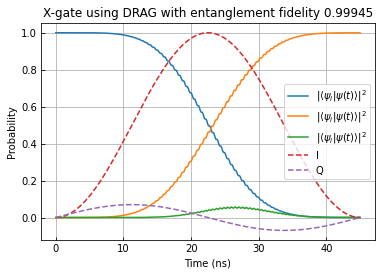

In [805]:
times_drag = np.linspace(0, args['tau_g'], 1000)
sol_drag_optimized = mesolve(H_drag, psi0, times_drag, args=args)
# Helper function to calculate overlap between two states

for i in range(3):
    plt.plot(sol_drag_optimized.times, [prob(sol_drag_optimized, t, i) for t in range(len(sol_drag_optimized.times))], label = r'$| \langle \psi_{i} | \psi(t) \rangle |^2$')

plt.plot(sol_drag_optimized.times, cosine_envelope(np.array(sol_drag_optimized.times), args['tau_g'])/np.max(cosine_envelope(times, args['tau_g'])), '--', label = 'I')
plt.plot(sol_drag_optimized.times, diff_cosine_envelope(np.array(sol_drag_optimized.times), args['tau_g'])/np.max(cosine_envelope(times, args['tau_g'])), '--', label = 'Q')

plt.legend()
plt.xlabel('Time (ns)')
plt.ylabel('Probability')
plt.tick_params(axis='both', direction = 'in')
plt.title(f'X-gate using DRAG with entanglement fidelity {round(fidelity,5)}')
plt.grid()

plt.savefig("DRAG_optimized.jpg", dpi=300)
plt.show()

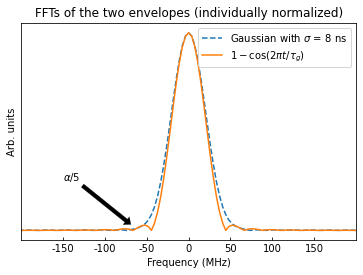

In [806]:
from scipy.fft import fftshift, fft, fftfreq
N = len(times_drag)
dt = times_drag[1] - times_drag[0]  # Time step
zero_padding = 5000
frequencies = fftshift(fftfreq(N + zero_padding, dt))
gauss_pulse = gauss(times_drag, args['tau_g']/2, args['sigma'])
gauss_padded = np.pad(gauss_pulse, (0, zero_padding), 'constant')
gauss_fft = fftshift(np.abs(fft(gauss_padded)))
plt.plot(frequencies, 20*gauss_fft/gauss_fft.max(), '--', label=f'Gaussian with $\\sigma$ = {sigm} ns')

cosine_pulse = cosine_envelope(times_drag, args['tau_g'])
cosine_padded = np.pad(cosine_pulse, (0, zero_padding), 'constant')
cosine_fft = fftshift(np.abs(fft(cosine_padded)))
plt.plot(frequencies, 20*cosine_fft/cosine_fft.max(), label=f'$1 - \cos(2\pi t / \\tau_g)$') # We divide by 31.3 to have equal amplitudes

plt.xlim(-0.2, 0.2)
plt.xticks([-0.15, -0.1, -0.05, 0, 0.05, 0.1, 0.15], ['-150', '-100', '-50', '0', '50', '100', '150'])
plt.xlabel('Frequency (MHz)')
plt.legend()
plt.yticks([])
plt.ylabel('Arb. units')
plt.title('FFTs of the two envelopes (individually normalized)')
plt.tick_params(axis='x', direction='in')

plt.annotate(r'$\alpha / 5$', xy=(alpha/5, 0.6), xytext=(-0.15, 5),
             arrowprops=dict(facecolor='black', shrink=2, headwidth=10, headlength=6, linewidth=0.2))

plt.savefig("FFTs_of_envelopes.jpg", dpi=300)

plt.show()